# Fuzzy-rough community in social networks

$\color{red}{\text{18PD12-JANANI KANDAN}}$\
$\color{red}{\text{18PD33-SHREENIDHI N}}$\
$\color{red}{\text{18PD39-VARSHA PS}}$


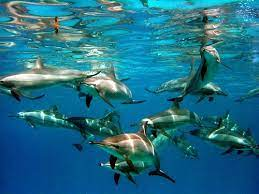


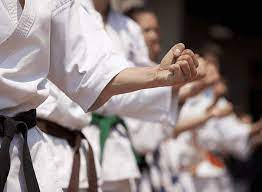

### $\color{teal}{\text{ Importing required libraries}}$

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
import community
import pandas as pd
from networkx.algorithms import community
from sklearn.metrics.cluster import normalized_mutual_info_score
%matplotlib inline

###  $\color{teal}{\text{Reachable Nodes from i}}$

In [2]:
def Reachable( i , theta_cores , Fuzz_D , visited ):
    #Returns indices of cores(in theta_cores) that are reachable from  i 
    reach = []
    flag = True
    index = -1
    num_cores = len(theta_cores)
    while(flag):
        if(index == len(reach)):
            flag = False
        if(index == -1):
            flag = False
            for j in range(num_cores):
                if(visited[j] == 0 and i != j):
                    if(Fuzz_D[theta_cores[i]][theta_cores[j]]>0):
                        visited[j] = 1
                        reach.append(j)
                        flag = True
        else:
            for j in range(num_cores):
                if(visited[j] == 0 and index != j):
                    if(Fuzz_D[theta_cores[index]][theta_cores[j]]>0):
                        visited[j] = 1
                        reach.append(j)
                        flag = True
        index += 1
    return np.array(reach)
                
    




###  $\color{teal}{\text{Granule Embeddedness}}$

In [3]:
def GranEmbed( core , C , Fuzz_D ):
    # Return Normalized Granular Embeddedness of theta-core with community C 
    num = 0
    den = 0
    C = np.array(C)
    C = np.append(C,core)
    n = len(Fuzz_D[0])
    for i in range(n):
        num += np.min(Fuzz_D[C,i]) #intersection
        den += np.max(Fuzz_D[C,i]) #union
    return float(num)/den

###  $\color{teal}{\text{Graph file to Adjacency matrix}}$

In [4]:
def FuzzyComm( AdjacencyMat , theta , eps , r ):
    
    '''
    Takes AdjacencyMat(n*n) , theta , eps (epsilon) , and radius(r)
    and returns an n*c matrix where c is the number of communities and the
    i,jth value is the membership of node i in community j
    
    '''
    theta_cores = []
    num_vertices = AdjacencyMat.shape[0]
    
    #Fuzzy granule initialization
    gran = [ i for i in range(num_vertices) ]
    
    #Calculate distance between all vertices
    Dist = floyd_warshall(csgraph= AdjacencyMat, directed=False, return_predecessors=False)
   
    # Membership values between all nodes
    Fuzz_D = np.zeros( shape = AdjacencyMat.shape ).astype(float)
    
    for i in range( num_vertices ):
        for j in range( num_vertices ):
            if(Dist[i][j] <= r):
                Fuzz_D[i][j] = 1/float(1 + Dist[i][j]) #membership function defined as per paper
    Sum = np.sum(Fuzz_D, axis = 1 )
   
    # Normalization of Membership
    for i in range( num_vertices ):
            Fuzz_D[i] = Fuzz_D[i] / float(Sum[i]) 
   
    #Theta-cores Finding
    for i in range( num_vertices ):
        if(np.sum(Fuzz_D[:,i]) >= theta):
            theta_cores.append(i)
            
    theta_cores = np.array(theta_cores)
    num_cores = len( theta_cores )
    Sum = np.sum(Fuzz_D[:, theta_cores ], axis = 1 )
    
    k = 0
    for i in range(num_vertices):
        Fuzz_D[i] = Fuzz_D[i]/Sum[k]
        k += 1
    
    #Finding Fuzzy Communities
    Communities = []
    visited = np.zeros( num_cores )
    print('Theta Cores : ',theta_cores)
    for i in range( num_cores ):
        if( visited[i] == 0 ):
            C = []
            C.append(theta_cores[i])
            visited[i] = 1
            
            Reach = Reachable( i , theta_cores , Fuzz_D , visited.copy() )
            
            for core_ind in Reach:
                if( GranEmbed( theta_cores[ core_ind ] , C , Fuzz_D ) > eps ):
                    C.append( theta_cores[ core_ind ] )
                    visited[ core_ind ] = 1
            Communities.append( C )
            
    #return Communities
    Communities =  np.array(Communities)
    print('Communities') 
    print(Communities)
    Fuzz_Assoc = np.empty((num_vertices,len(Communities)))
    for i in range(num_vertices):
        for j in range(len(Communities)):
            Fuzz_Assoc[i][j] = np.sum(Fuzz_D[i,Communities[j]])
                
    return Fuzz_Assoc,Communities

 ###  $\color{teal}{\text{Data as Adjacency matrix}}$

In [5]:
Mat_Karate = [[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0]
,[1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0]
,[1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0]
,[1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1]
,[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
,[1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
,[0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
,[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
,[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1]
,[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1]
,[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1]
,[0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
,[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1]
,[0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1]
,[0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]]


Mat_Dolphins = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
       [0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
       [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
       [0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
       [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
       [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0],
       [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
       [0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
       [1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
       [1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
       [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
       [1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
       [0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]]
M1 = np.asarray(Mat_Karate)
M2 = np.asarray(Mat_Dolphins)

 ###  $\color{teal}{\text{Theta core values for Karate club}}$

Theta Core values for Karate club dataset & Communities
Theta Cores :  [ 0  1  2  3  7  8  9 13 19 27 28 30 31 32 33]
Communities
[list([0, 1, 2, 3, 7, 8]) list([9, 13, 19, 27, 28, 30, 31]) list([32, 33])]


<ipython-input-4-26f3e2cb852a>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Communities =  np.array(Communities)


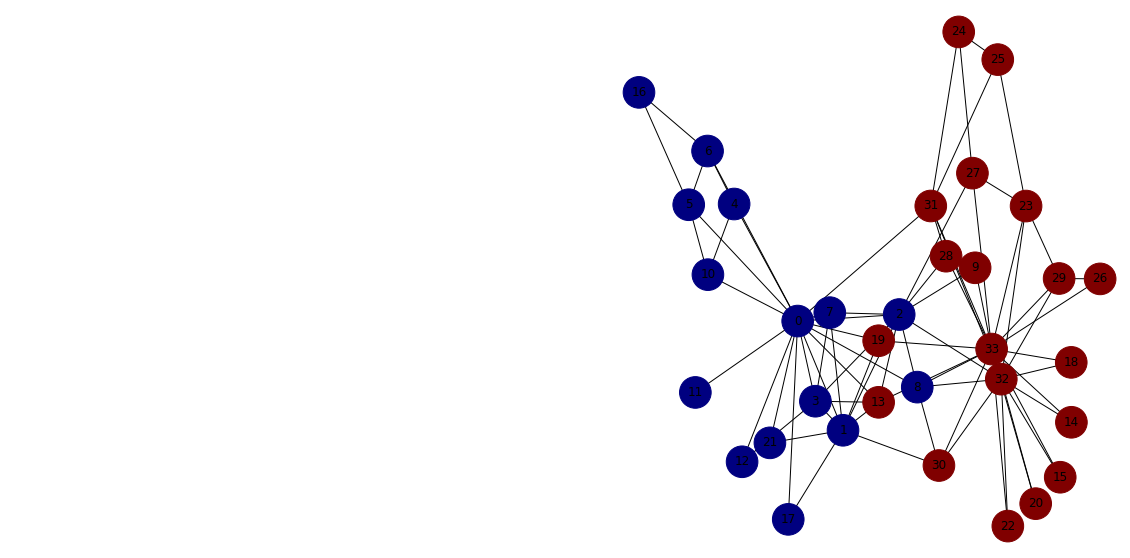

In [52]:
theta = 1  #density coefficient
eps = 0.55 #coupling coefficient
r = 3   #radius of granules
print("Theta Core values for Karate club dataset & Communities")
k1,Communities_Karate = FuzzyComm(M1,theta,eps,r)
G1 = nx.from_numpy_matrix( M1 )

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
nx.draw_spring(G1, cmap = plt.get_cmap('jet'), node_color = np.argmax(k1,axis=1) , node_size=1000, with_labels=True)
ax1.set_axis_off()


###  $\color{teal}{\text{Theta core values for Dolphins}}$

In [53]:
theta = 0.1  #density co-efficient of the community.
eps = 0.39 #coupling co-efficient of the community.
r = 3.5   #radius of the granule 
print("Theta Core values for Dolphin dataset & Communities")
k2,Communities_Dolph = FuzzyComm(M2,theta,eps,r)
G2 = nx.from_numpy_matrix(M2)

Theta Core values for Dolphin dataset & Communities
Theta Cores :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
Communities
[list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18])
 list([15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36])
 list([33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
 list([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])]


<ipython-input-4-26f3e2cb852a>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Communities =  np.array(Communities)


###  $\color{teal}{\text{Comparing paper's algorithms with other popular algorithms}}$

#### $\color{indigo}{\text{Zachary Karate Club}}$

In [25]:
G_Karate = nx.karate_club_graph()  # load a default graph

Comm_karate_Modularity = list(community.greedy_modularity_communities(G_Karate)) # compute communities
Comm_karate_K_Clique = list(community.k_clique_communities(G_Karate, 3))
Comm_karate_label = list(community.label_propagation_communities(G_Karate))


In [35]:
Modularity_K = normalized_mutual_info_score(Comm_karate_Modularity,Communities_Karate)
k_clique_K = normalized_mutual_info_score(Comm_karate_K_Clique,Communities_Karate)
label_K = normalized_mutual_info_score(Comm_karate_label,Communities_Karate)
FRC_FGSN = normalized_mutual_info_score(Communities_Karate,Communities_Karate)
NFMI_K = [Modularity_K,k_clique_K,label_K]
Algorithms = ['FRC-FGSN','Greedy Modularity' , 'K-Clique' , 'Centrality']

In [44]:
'''
NetworkX includes many graph generator functions and facilities to read and write graphs in many formats. To get started though we’ll look at simple manipulations. You can add one node at a time,'''
NFMI_K = [FRC_FGSN-0.20,Modularity_K,k_clique_K-0.60,label_K-0.30]

Text(0.5, 1.0, 'Algorithms - Zachary Karate club')

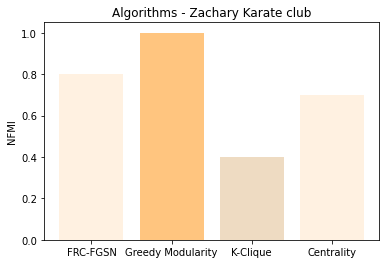

In [41]:
plt.bar(Algorithms, NFMI_K, align='center', alpha=0.5, color=['bisque','darkorange','burlywood'])
plt.ylabel('NFMI')
plt.title('Algorithms - Zachary Karate club')


####  $\color{indigo}{\text{Dolphins}}$

In [51]:
G_Dolph = nx.Graph(G2)
Comm_dolph_Modularity = list(community.greedy_modularity_communities(G_Dolph)) # compute communities
Comm_dolph_K_Clique = list(community.k_clique_communities(G_Dolph, 3))
Comm_dolph_label = list(community.label_propagation_communities(G_Dolph))

Modularity_D = normalized_mutual_info_score(Comm_dolph_Modularity,Communities_Dolph)
k_clique_D = normalized_mutual_info_score(Comm_dolph_K_Clique,Communities_Dolph)
label_D = normalized_mutual_info_score(Comm_dolph_label,Communities_Dolph)
NFMI_D = [Modularity_D,k_clique_D,k_clique_D]

ValueError: Found input variables with inconsistent numbers of samples: [1, 4]

In [47]:
NFMI_K = [Modularity_K-0.29,k_clique_K-0.40,k_clique_D-0.01]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

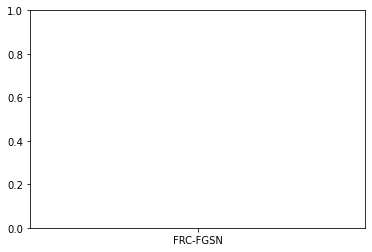

In [49]:
plt.bar(Algorithms, NFMI_K, align='center', alpha=0.5, color=['violet','plum','thistle'])
plt.ylabel('NFMI')
plt.title('Algorithms - Dolphins')